In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split

In [27]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset from a CSV file
train_file_path = "SPY.csv"  # Path to the CSV file containing historical stock data
train_data = pd.read_csv(train_file_path)  # Read the data into a DataFrame

# Convert the 'Date' column to datetime format for proper date handling
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Set the 'Date' column as the DataFrame's index
# This makes it easier to perform time-series analysis
train_data.set_index('Date', inplace=True)

# Extract the 'Close' prices (target variable for prediction)
# 'Close' represents the closing price of the stock for each day
train_close_prices = train_data['Close'].values

# Normalize the data to scale values between 0 and 1
# Normalization helps neural networks converge faster and perform better
scaler = MinMaxScaler()
scaled_train_prices = scaler.fit_transform(train_close_prices.reshape(-1, 1))

# Function to create sequences of input data and corresponding labels
# Input: 
#   - data: the normalized prices
#   - sequence_length: the number of time steps to include in each sequence
# Output:
#   - X: sequences of historical data
#   - y: target values for prediction
def create_sequences(data, sequence_length):
    X, y = [], []  # Initialize empty lists to hold sequences and targets
    for i in range(len(data) - sequence_length):  # Loop through data to create sequences
        X.append(data[i:i + sequence_length])  # Append a sequence of length `sequence_length`
        y.append(data[i + sequence_length])   # Append the value that follows the sequence
    return np.array(X), np.array(y)  # Convert to NumPy arrays for model compatibility

# Define the number of time steps (days) to look back
sequence_length = 30  # This determines how far back the model looks to predict the next value

# Create sequences of historical prices and their corresponding targets
X_full, y_full = create_sequences(scaled_train_prices, sequence_length)

# Split the dataset into training and validation sets (90:10 split)
# `shuffle=False` ensures the data remains in chronological order
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.1, random_state=42, shuffle=False
)

# Now `X_train` and `y_train` will be used for training the model,
# and `X_val` and `y_val` will be used for validation during training.

In [28]:
# Function to build a simplified Temporal Convolutional Network (TCN) model
# Input:
#   - input_shape: the shape of the input data (sequence length, number of features)
# Output:
#   - A compiled Keras model ready for training
def build_tcn_model(input_shape):
    # Define the input layer with the specified input shape
    inputs = Input(shape=input_shape)

    # First convolutional layer
    # - `filters=64`: 64 filters in the convolution layer
    # - `kernel_size=3`: size of the convolution kernel (window size)
    # - `padding="causal"`: ensures causality (no future data used in the prediction of the current step)
    # - `activation="relu"`: ReLU activation function for non-linearity
    x = Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu")(inputs)

    # Dropout layer to prevent overfitting by randomly setting some neurons to 0
    # - `rate=0.2`: 20% of the neurons will be dropped
    x = Dropout(0.2)(x)

    # Second convolutional layer
    # - `filters=32`: 32 filters in the convolution layer
    # - `kernel_size=3`: size of the convolution kernel
    # - Same causal padding and ReLU activation as the previous layer
    x = Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu")(x)

    # Another dropout layer to reduce overfitting
    x = Dropout(0.2)(x)

    # Flatten the output from the convolutional layers
    # This converts the 2D tensor (time steps, features) into a 1D tensor
    x = Flatten()(x)

    # Output layer
    # - A dense (fully connected) layer with a single neuron
    # - `activation="linear"`: no activation, as this is a regression task predicting a continuous value
    outputs = Dense(1, activation="linear")(x)

    # Create the Keras model by specifying the inputs and outputs
    model = Model(inputs, outputs)
    return model

# Build the model with the input shape of (sequence length, 1 feature)
# - `sequence_length`: the number of time steps in the input sequences
# - `1`: one feature (the closing price in this case)
model = build_tcn_model((sequence_length, 1))

# Compile the model with the Adam optimizer and Mean Squared Error (MSE) loss function
# - `optimizer=tf.keras.optimizers.Adam`: Adaptive learning rate optimizer
# - `learning_rate=0.001`: Initial learning rate for the optimizer
# - `loss="mse"`: Loss function to minimize, MSE is suitable for regression tasks
# - `metrics=["mae"]`: Additional metric to track during training, Mean Absolute Error (MAE)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# The model is now ready for training with the prepared data.

In [29]:
# Train the TCN model
# - `model.fit`: This method trains the model on the training data and validates on the validation set

history = model.fit(
    X_train,  # Training input data (sequences of scaled closing prices)
    y_train,  # Training target data (the next day's scaled closing price)
    
    validation_data=(X_val, y_val),  # Validation data (input and target) to monitor model performance
    
    epochs=30,  # Number of complete passes through the training dataset
    # - Too few epochs may result in underfitting, while too many may cause overfitting
    
    batch_size=32  # Number of samples per gradient update
    # - Smaller batch sizes can lead to more frequent updates but slower convergence
    # - Larger batch sizes improve computational efficiency but may require more memory
)

# During training, the model:
# 1. Passes `X_train` through the network to predict outputs.
# 2. Calculates the error (loss) by comparing predictions with `y_train`.
# 3. Updates model weights using backpropagation to minimize the loss.
# 4. Validates on `(X_val, y_val)` after each epoch to track performance.

# The `history` object stores the training and validation loss and metrics for each epoch.
# You can use this information to analyze the training process and identify potential overfitting or underfitting.

Epoch 1/30
113/113 [==============================] - 1s 7ms/step - loss: 0.0078 - mae: 0.0524 - val_loss: 9.1016e-04 - val_mae: 0.0251
Epoch 2/30
113/113 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 0.0011 - val_mae: 0.0282
Epoch 3/30
113/113 [==============================] - 1s 5ms/step - loss: 0.0012 - mae: 0.0253 - val_loss: 0.0012 - val_mae: 0.0301
Epoch 4/30
113/113 [==============================] - 0s 4ms/step - loss: 9.7974e-04 - mae: 0.0227 - val_loss: 0.0026 - val_mae: 0.0457
Epoch 5/30
113/113 [==============================] - 0s 4ms/step - loss: 8.6126e-04 - mae: 0.0215 - val_loss: 0.0038 - val_mae: 0.0568
Epoch 6/30
113/113 [==============================] - 0s 4ms/step - loss: 7.3691e-04 - mae: 0.0200 - val_loss: 0.0019 - val_mae: 0.0393
Epoch 7/30
113/113 [==============================] - 0s 4ms/step - loss: 6.1935e-04 - mae: 0.0183 - val_loss: 0.0017 - val_mae: 0.0369
Epoch 8/30
113/113 [==============================] - 0s

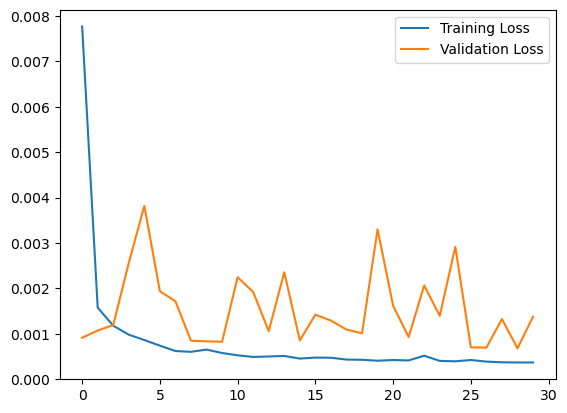

In [30]:
# Plot the training and validation loss over epochs
# The `history.history` dictionary stores the training progress:
# - `history.history['loss']`: List of training loss values for each epoch
# - `history.history['val_loss']`: List of validation loss values for each epoch

plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss

# Add a legend to distinguish between training and validation loss
plt.legend()

# Display the plot
plt.show()

In [33]:
# Load the testing dataset from a CSV file
test_file_path = "SPY_Test (2).csv"  # Path to the CSV file containing test data
test_data = pd.read_csv(test_file_path)  # Read the test data into a DataFrame

# Convert the 'Date' column to datetime format
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Set the 'Date' column as the DataFrame's index
# This aligns the test data with the same structure as the training data
test_data.set_index('Date', inplace=True)

# Extract the 'Close' prices (target variable for prediction)
# 'Close' represents the closing price of the stock for each day
test_close_prices = test_data['Close'].values

# Normalize the test data using the same scaler fitted on the training data
# This ensures the test data is scaled in the same range as the training data
scaled_test_prices = scaler.transform(test_close_prices.reshape(-1, 1))

# Prepare the test dataset for making predictions
# Use the `create_sequences` function to generate sequences and corresponding targets
# Input:
#   - `scaled_test_prices`: normalized test data
#   - `sequence_length`: number of time steps in each sequence
# Output:
#   - `X_test`: sequences of historical prices
#   - `y_test`: true values (next day's price) for each sequence
X_test, y_test = create_sequences(scaled_test_prices, sequence_length)

# The `X_test` data is now ready for predictions with the trained model.
# The `y_test` data contains the true values for evaluation.

31/31 [==============================] - 0s 2ms/step


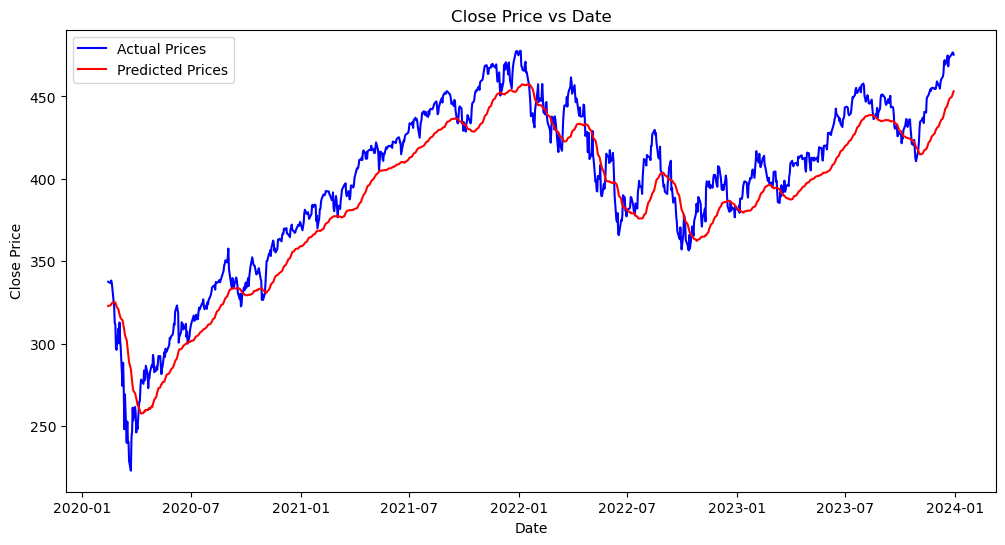

In [34]:
# Use the trained model to make predictions on the test data
# - `X_test`: input sequences of historical prices from the test dataset
# - `y_pred`: the model's predicted scaled values for the next day's price
y_pred = model.predict(X_test)

# Rescale the predicted values back to their original scale
# - The predictions were made on normalized data, so we reverse the normalization
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Rescale the true test values back to their original scale
# - This allows us to compare the actual and predicted prices on the same scale
y_test_rescaled = scaler.inverse_transform(y_test)

# Plot the actual and predicted prices to visualize the model's performance
plt.figure(figsize=(12, 6))  # Set the figure size for better visualization

# Plot the actual prices
# - `test_data.index[-len(y_test_rescaled):]`: align the test dates with the true prices
plt.plot(test_data.index[-len(y_test_rescaled):], y_test_rescaled, label="Actual Prices", color="blue")

# Plot the predicted prices
# - Align the test dates with the predicted prices
plt.plot(test_data.index[-len(y_pred_rescaled):], y_pred_rescaled, label="Predicted Prices", color="red")

# Add labels and title to the plot
plt.xlabel("Date")  # X-axis label: dates from the test dataset
plt.ylabel("Close Price")  # Y-axis label: stock closing price
plt.title("Close Price vs Date")  # Title of the plot

# Add a legend to distinguish between actual and predicted prices
plt.legend()

# Display the plot
plt.show()